# CellPhone Db from Marker genes

We ran this in a separate conda environment following these steps:

Install minicodna:

```bash
mkdir -p ~/miniconda3
wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh -O ~/miniconda3/miniconda.sh
bash ~/miniconda3/miniconda.sh -b -u -p ~/miniconda3
rm ~/miniconda3/miniconda.sh
```

activate it and create a new env where you install cellphonedb and a kernel tu run in jupyter nb's

```bash
source ~/miniconda3/bin/activate
conda create -n cpdb2
pip install cellphonedb
pip install -U ipykernel
python -m ipykernel install --user --name 'cpdb2'
```

## Download DB

In [1]:
import os
import pandas as pd
import scanpy as sc

os.chdir('/root/host_home/luca')

from IPython.display import HTML, display
from cellphonedb.utils import db_releases_utils

display(HTML(db_releases_utils.get_remote_database_versions_html()['db_releases_html_table']))


In [ ]:
backup_dir = '/root/datos/maestria/netopaas/luca_explore'
wilcox_dir = '/root/host_home/luca/nb_DE_wilcox/wilcoxon_DE'

# -- Version of the databse
cpdb_version = 'v5.0.0'
# os.mkdir(f'{backup_dir}/cellphoneDB')
cpdb_target_dir = os.path.join(backup_dir, '/cellphoneDB/db/', cpdb_version)

In [ ]:
# from cellphonedb.utils import db_utils
# db_utils.download_database(cpdb_target_dir, cpdb_version)

Downloaded cellphonedb.zip into /cellphoneDB/db/v5.0.0
Downloaded complex_input.csv into /cellphoneDB/db/v5.0.0
Downloaded gene_input.csv into /cellphoneDB/db/v5.0.0
Downloaded interaction_input.csv into /cellphoneDB/db/v5.0.0
Downloaded protein_input.csv into /cellphoneDB/db/v5.0.0
Downloaded uniprot_synonyms.tsv into /cellphoneDB/db/v5.0.0/sources
Downloaded transcription_factor_input.csv into /cellphoneDB/db/v5.0.0/sources


We only have 

The statistial method accepts 4 input files (3 mandatory).

    cpdb_file_path: (mandatory) path to the database cellphonedb.zip.
    meta_file_path: (mandatory) path to the meta file linking cell barcodes to cluster labels metadata.tsv.
    counts_file_path: (mandatory) paths to normalized counts file (not z-transformed), either in text format or h5ad (recommended) normalised_log_counts.h5ad.
    microenvs_file_path (optional) path to microenvironment file that groups cell types/clusters by microenvironments. When providing a microenvironment file, CellphoneDB will restrict the interactions to those cells within the microenvironment.

The microenvs_file_path content will depend on the biological question that the researcher wants to answer.

    In this example we are studying how cell-cell interactions change between a subset of immune cells and trophoblast cells as the trophoblast differentiate and invade the maternal uterus. This module will randomly permute the cluster labels of all cells whitin each microenvironement (microenvs_file_path) 1,000 times (default) and determine the mean of the average receptor expression level in a cluster and the average ligand expression level in the interacting cluster. Then, we will obtain a P-value for the likelihood of cell-type specificity of a given receptor–ligand complex.


We will define the paths of the files to use, if they do not exist we will create them

In [ ]:
# os.mkdir(out_path)


## I-II

In [3]:
time = 'I-II'
cpdb_file_path = f'{cpdb_target_dir}/cellphonedb.zip'
meta_file_path = f'{backup_dir}/cellphoneDB/metadata.tsv'
counts_file_path = f'{backup_dir}/cellphoneDB/normalised_log_counts.h5ad'
microenvs_file_path = f'{backup_dir}/cellphoneDB/microenvironment.tsv'
out_path = f'{backup_dir}/cellphoneDB/method2'

### Metadata

The metadata file is composed of two columns:

    barcode_sample: this column indicates the barcode of each cell in the experiment.
    cell_type: this column denotes the cell label assigned.

But we only have a count matrix with some cell_types per study as rows.. so we wll have to extract the cell types from the rows of the count matrix

In [19]:
count_matrix = pd.read_csv(f'{wilcox_dir}/auc_count_cellphonedb_{time}.csv', index_col=0)
count_matrix['cell_type'] = None

for i, name in enumerate(count_matrix.index):
    if 'extended' in name:
        count_matrix.at[name, 'cell_type'] = '_'.join(name.split('_')[:-1])
    else:
        count_matrix.at[name, 'cell_type'] = '_'.join(name.split('_')[:-2])

count_matrix['barcode_sample'] = count_matrix.index
# count_matrix.index = range(count_matrix.shape[0])

count_matrix[['cell_type', 'barcode_sample']].to_csv(meta_file_path, sep='\t')     

metadata = pd.read_csv(meta_file_path, sep = '\t', index_col=0)
metadata.head(3)

,cell_type,barcode_sample
Tumor Club_AT2_LUAD_Chen_Zhang,Tumor Club_AT2_LUAD,Tumor Club_AT2_LUAD_Chen_Zhang
Tumor LUAD_NE_LUSC_Chen_Zhang,Tumor LUAD_NE_LUSC,Tumor LUAD_NE_LUSC_Chen_Zhang
Tumor LUSC_LUAD_mitotic_Chen_Zhang,Tumor LUSC_LUAD_mitotic,Tumor LUSC_LUAD_mitotic_Chen_Zhang


### Adata

In [23]:
import scanpy as sc
count_matrix.index = count_matrix['barcode_sample']
count_matrix_ = count_matrix.drop(columns=['cell_type', 'barcode_sample'])

adata = sc.AnnData(count_matrix_)
adata.obs = metadata
adata.write_h5ad(counts_file_path)
adata

AnnData object with n_obs × n_vars = 128 × 5989
    obs: 'cell_type', 'barcode_sample'

In [24]:
adata = sc.read_h5ad(counts_file_path)
adata.X

array([[0.47535693, 0.49689842, 0.45497191, ..., 0.53133326, 0.49960198,
        0.48728702],
       [0.5297259 , 0.50456307, 0.44056147, ..., 0.55012622, 0.51942452,
        0.53846259],
       [0.46856513, 0.49391311, 0.43790367, ..., 0.50488531, 0.50015951,
        0.50005014],
       ...,
       [0.41151308, 0.37647562, 0.38895186, ..., 0.42398987, 0.36652169,
        0.86436879],
       [0.46184696, 0.40558537, 0.41344536, ..., 0.64603924, 0.71337615,
        0.41579046],
       [0.68884305, 0.88275714, 0.68730409, ..., 0.76405129, 0.64413184,
        0.84966684]])

In [25]:
list(adata.obs.index).sort() == list(metadata['barcode_sample']).sort()

True

In [6]:
from cellphonedb.src.core.methods import cpdb_statistical_analysis_method
cpdb_results = cpdb_statistical_analysis_method.call(
    cpdb_file_path = cpdb_file_path,                 # mandatory: CellphoneDB database zip file.
    meta_file_path = meta_file_path,                 # mandatory: tsv file defining barcodes to cell label.
    counts_file_path = counts_file_path,             # mandatory: normalized count matrix - a path to the counts file, or an in-memory AnnData object
    counts_data = 'hgnc_symbol',                     # defines the gene annotation in counts matrix.
    # active_tfs_file_path = active_tf_path,           # optional: defines cell types and their active TFs.
    # microenvs_file_path = microenvs_file_path,       # optional (default: None): defines cells per microenvironment.
    score_interactions = True,                       # optional: whether to score interactions or not. 
    iterations = 1000,                               # denotes the number of shufflings performed in the analysis.
    threshold = 0.1,                                 # defines the min % of cells expressing a gene for this to be employed in the analysis.
    threads = 8,                                     # number of threads to use in the analysis.
    debug_seed = 42,                                 # debug randome seed. To disable >=0.
    result_precision = 3,                            # Sets the rounding for the mean values in significan_means.
    pvalue = 0.3,                                   # P-value threshold to employ for significance.
    subsampling = False,                             # To enable subsampling the data (geometri sketching).
    subsampling_log = False,                         # (mandatory) enable subsampling log1p for non log-transformed data inputs.
    subsampling_num_pc = 100,                        # Number of componets to subsample via geometric skectching (dafault: 100).
    subsampling_num_cells = adata.shape[0]/3,                    # Number of cells to subsample (integer) (default: 1/3 of the dataset).
    separator = '|',                                 # Sets the string to employ to separate cells in the results dataframes "cellA|CellB".
    debug = False,                                   # Saves all intermediate tables employed during the analysis in pkl format.
    output_path = out_path,                          # Path to save results.
    output_suffix = None                             # Replaces the timestamp in the output files by a user defined string in the  (default: None).
    )


Reading user files...
The following user files were loaded successfully:
/root/datos/maestria/netopaas/luca_explore/cellphoneDB/normalised_log_counts.h5ad
/root/datos/maestria/netopaas/luca_explore/cellphoneDB/metadata.tsv
[ ][CORE][02/04/25-04:39:45][INFO] [Cluster Statistical Analysis] Threshold:0.1 Iterations:1000 Debug-seed:42 Threads:8 Precision:3
[ ][CORE][02/04/25-04:39:45][WARNING] Debug random seed enabled. Set to 42
[ ][CORE][02/04/25-04:39:47][INFO] Running Real Analysis
[ ][CORE][02/04/25-04:39:47][INFO] Running Statistical Analysis


100%|██████████| 1000/1000 [00:10<00:00, 94.96it/s]


[ ][CORE][02/04/25-04:39:58][INFO] Building Pvalues result
[ ][CORE][02/04/25-04:39:59][INFO] Building results
[ ][CORE][02/04/25-04:39:59][INFO] Scoring interactions: Filtering genes per cell type..


100%|██████████| 56/56 [00:00<00:00, 538.03it/s]

[ ][CORE][02/04/25-04:39:59][INFO] Scoring interactions: Calculating mean expression of each gene per group/cell type..



100%|██████████| 56/56 [00:00<00:00, 1049.70it/s]


[ ][CORE][02/04/25-04:40:00][INFO] Scoring interactions: Calculating scores for all interactions and cell types..


100%|██████████| 3136/3136 [01:24<00:00, 37.27it/s]


Saved deconvoluted to /root/datos/maestria/netopaas/luca_explore/cellphoneDB/method2/statistical_analysis_deconvoluted_04_02_2025_044127.txt
Saved deconvoluted_percents to /root/datos/maestria/netopaas/luca_explore/cellphoneDB/method2/statistical_analysis_deconvoluted_percents_04_02_2025_044127.txt
Saved means to /root/datos/maestria/netopaas/luca_explore/cellphoneDB/method2/statistical_analysis_means_04_02_2025_044127.txt
Saved pvalues to /root/datos/maestria/netopaas/luca_explore/cellphoneDB/method2/statistical_analysis_pvalues_04_02_2025_044127.txt
Saved significant_means to /root/datos/maestria/netopaas/luca_explore/cellphoneDB/method2/statistical_analysis_significant_means_04_02_2025_044127.txt
Saved interaction_scores to /root/datos/maestria/netopaas/luca_explore/cellphoneDB/method2/statistical_analysis_interaction_scores_04_02_2025_044127.txt


In [ ]:
from cellphonedb.src.core.methods import cpdb_analysis_method

cpdb_results = cpdb_analysis_method.call(
    cpdb_file_path = cpdb_file_path,           # mandatory: CellphoneDB database zip file.
    meta_file_path = meta_file_path,           # mandatory: tsv file defining barcodes to cell label.
    counts_file_path = adata,       # mandatory: normalized count matrix - a path to the counts file, or an in-memory AnnData object
    counts_data = 'hgnc_symbol',               # defines the gene annotation in counts matrix.
    # microenvs_file_path = microenvs_file_path, # optional (default: None): defines cells per microenvironment.
    score_interactions = True,                 # optional: whether to score interactions or not. 
    output_path = out_path,                    # Path to save results    microenvs_file_path = None,
    separator = '|',                           # Sets the string to employ to separate cells in the results dataframes "cellA|CellB".
    threads = 8,                               # number of threads to use in the analysis.
    threshold = 0.1,                           # defines the min % of cells expressing a gene for this to be employed in the analysis.
    result_precision = 3,                      # Sets the rounding for the mean values in significan_means.
    debug = False,                             # Saves all intermediate tables emplyed during the analysis in pkl format.
    output_suffix = None                       # Replaces the timestamp in the output files by a user defined string in the  (default: None)
)



In [53]:
cpdb_results['means'].columns[:14]

Index(['id_cp_interaction', 'interacting_pair', 'partner_a', 'partner_b',
       'gene_a', 'gene_b', 'secreted', 'receptor_a', 'receptor_b',
       'annotation_strategy', 'is_integrin', 'directionality',
       'classification', 'B cell|B cell'],
      dtype='object')

In [ ]:
cpdb_results['means']

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,...,transitional club/AT2|Tumor LUSC,transitional club/AT2|Tumor LUSC_LUAD,transitional club/AT2|Tumor LUSC_LUAD_mitotic,transitional club/AT2|cDC1,transitional club/AT2|cDC2,transitional club/AT2|myeloid dividing,transitional club/AT2|nan,transitional club/AT2|pDC,transitional club/AT2|stromal dividing,transitional club/AT2|transitional club/AT2
47,CPI-SS0EE09A201,CDH2_CDH2,simple:P19022,simple:P19022,CDH2,CDH2,False,False,False,curated,...,0.502,0.508,0.506,0.669,0.488,0.485,0.506,0.481,0.719,0.514
48,CPI-SS0ADFF0666,CDH2_FCER2,simple:P19022,simple:P06734,CDH2,FCER2,True,False,True,curated,...,0.506,0.505,0.513,0.497,0.502,0.501,0.504,0.499,0.491,0.498
49,CPI-SS0DA0F5556,CDH3_CDH3,simple:P22223,simple:P22223,CDH3,CDH3,False,False,False,curated,...,0.592,0.670,0.624,0.582,0.592,0.596,0.661,0.581,0.587,0.698
50,CPI-SS00C24ED50,CDH5_CDH5,simple:P33151,simple:P33151,CDH5,CDH5,False,False,False,curated,...,0.477,0.483,0.490,0.470,0.474,0.472,0.478,0.471,0.464,0.474
51,CPI-SS0C53F7672,CDH6_CDH6,simple:P55285,simple:P55285,CDH6,CDH6,False,False,False,curated,...,0.479,0.499,0.500,0.474,0.475,0.474,0.493,0.474,0.690,0.475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2897,CPI-CS09A35DD21,Prostacyclin_byPTGIS_PTGIR,complex:Prostacyclin_byPTGIS,simple:P43119,NaN,PTGIR,True,False,True,curated,...,0.454,0.467,0.464,0.451,0.485,0.451,0.473,0.461,0.624,0.437
2898,CPI-SS0CBC7840D,PTPRC_CD22,simple:P08575,simple:P20273,PTPRC,CD22,False,False,True,curated,...,0.409,0.412,0.418,0.401,0.414,0.432,0.411,0.404,0.406,0.405
2899,CPI-SS0822AEF5F,PTPRC_MRC1,simple:P08575,simple:P22897,PTPRC,MRC1,False,False,True,curated,...,0.437,0.405,0.419,0.403,0.482,0.519,0.406,0.409,0.402,0.402
2903,CPI-SS0ABEE4D3D,RBP4_STRA6,simple:P02753,simple:Q9BX79,RBP4,STRA6,True,False,True,curated,...,0.490,0.497,0.500,0.484,0.483,0.492,0.489,0.498,0.699,0.484


In [9]:
cpdb_results['significant_means'].head(2)

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,...,transitional club/AT2|Tumor LUSC,transitional club/AT2|Tumor LUSC_LUAD,transitional club/AT2|Tumor LUSC_LUAD_mitotic,transitional club/AT2|cDC1,transitional club/AT2|cDC2,transitional club/AT2|myeloid dividing,transitional club/AT2|nan,transitional club/AT2|pDC,transitional club/AT2|stromal dividing,transitional club/AT2|transitional club/AT2
67,CPI-SS001BF66E8,CEACAM6_CEACAM6,simple:P40199,simple:P40199,CEACAM6,CEACAM6,False,False,False,curated,...,NaN,0.646,0.65,NaN,NaN,NaN,0.676,NaN,0.626,0.706
537,CPI-SS0C1332E73,CTSG_FPR1,simple:P08311,simple:P21462,CTSG,FPR1,True,False,True,curated,...,NaN,NaN,NaN,NaN,0.582,0.593,NaN,NaN,NaN,NaN


In [40]:
cpdb_results['interaction_scores']

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,...,transitional club/AT2|Tumor LUSC,transitional club/AT2|Tumor LUSC_LUAD,transitional club/AT2|Tumor LUSC_LUAD_mitotic,transitional club/AT2|cDC1,transitional club/AT2|cDC2,transitional club/AT2|myeloid dividing,transitional club/AT2|nan,transitional club/AT2|pDC,transitional club/AT2|stromal dividing,transitional club/AT2|transitional club/AT2
47,CPI-SS0EE09A201,CDH2_CDH2,simple:P19022,simple:P19022,CDH2,CDH2,False,False,False,curated,...,1.292,1.600,1.495,11.096,0.444,0.277,1.509,0.030,14.023,1.966
48,CPI-SS0ADFF0666,CDH2_FCER2,simple:P19022,simple:P06734,CDH2,FCER2,True,False,True,curated,...,1.026,0.924,1.492,0.397,0.759,0.665,0.893,0.534,0.000,0.499
49,CPI-SS0DA0F5556,CDH3_CDH3,simple:P22223,simple:P22223,CDH3,CDH3,False,False,False,curated,...,3.308,20.080,10.283,1.060,3.336,4.209,18.254,0.976,2.227,26.221
50,CPI-SS00C24ED50,CDH5_CDH5,simple:P33151,simple:P33151,CDH5,CDH5,False,False,False,curated,...,0.302,0.441,0.601,0.145,0.237,0.191,0.337,0.156,0.000,0.239
51,CPI-SS0C53F7672,CDH6_CDH6,simple:P55285,simple:P55285,CDH6,CDH6,False,False,False,curated,...,0.014,0.070,0.071,0.003,0.003,0.003,0.053,0.003,0.581,0.003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2897,CPI-CS09A35DD21,Prostacyclin_byPTGIS_PTGIR,complex:Prostacyclin_byPTGIS,simple:P43119,NaN,PTGIR,True,False,True,curated,...,0.008,0.013,0.012,0.007,0.020,0.007,0.016,0.011,0.071,0.002
2898,CPI-SS0CBC7840D,PTPRC_CD22,simple:P08575,simple:P20273,PTPRC,CD22,False,False,True,curated,...,0.843,1.145,1.686,0.189,1.323,2.870,1.010,0.408,0.603,0.514
2899,CPI-SS0822AEF5F,PTPRC_MRC1,simple:P08575,simple:P22897,PTPRC,MRC1,False,False,True,curated,...,4.703,1.456,2.875,1.214,9.213,12.960,1.574,1.851,1.134,1.170
2903,CPI-SS0ABEE4D3D,RBP4_STRA6,simple:P02753,simple:Q9BX79,RBP4,STRA6,True,False,True,curated,...,0.254,0.355,0.393,0.167,0.165,0.280,0.244,0.367,3.082,0.176


### Plotting interactions

In [10]:
import os
import anndata as ad
import pandas as pd
import ktplotspy as kpy
import matplotlib.pyplot as plt
%matplotlib inline


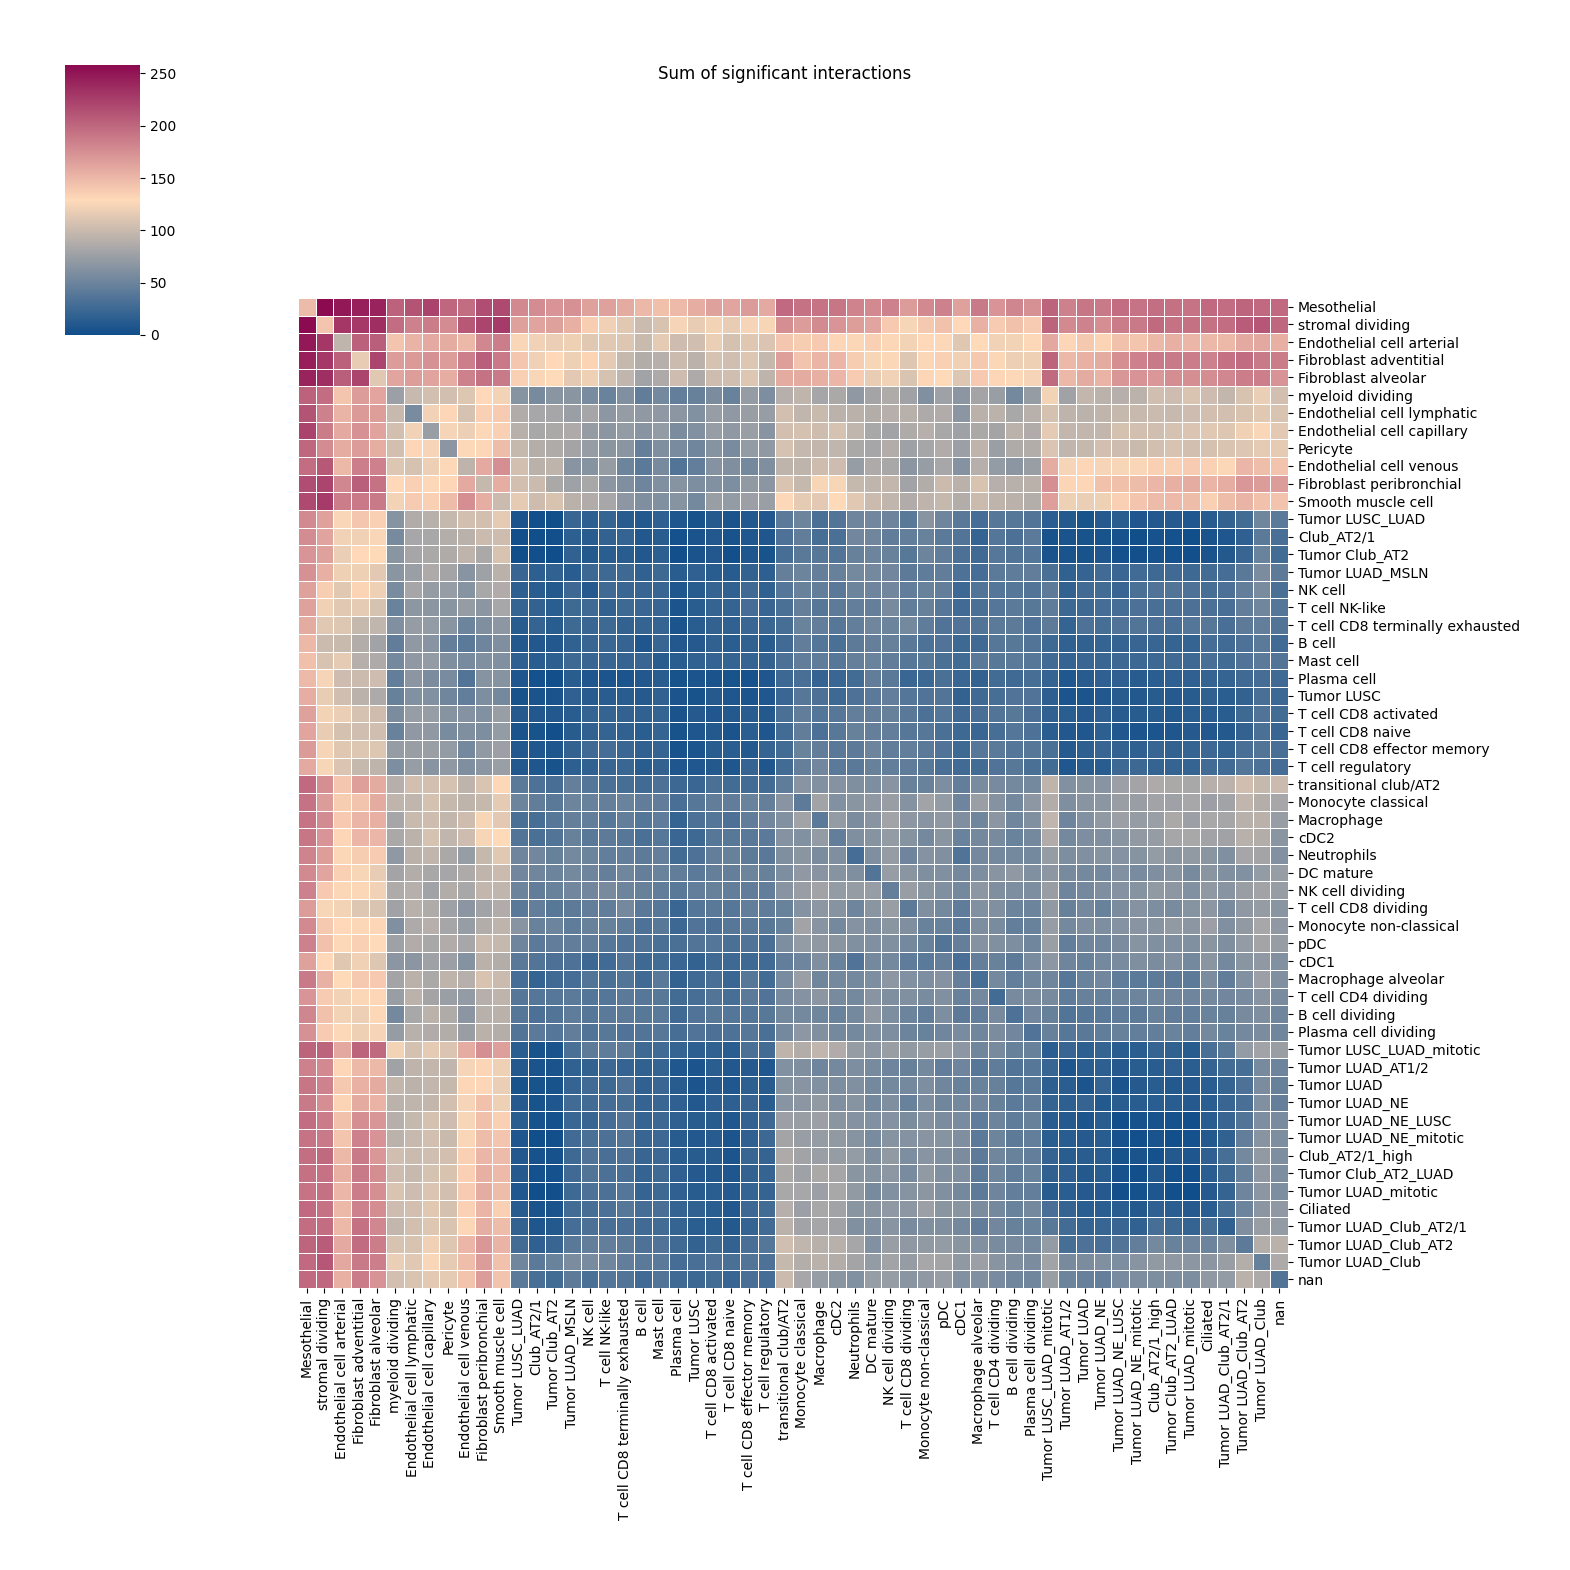

In [11]:
kpy.plot_cpdb_heatmap(pvals = cpdb_results['pvalues'],
                      degs_analysis = False,
                      figsize = (15, 15),
                      title = "Sum of significant interactions")


In [13]:
pvals  = cpdb_results['pvalues']
means  = cpdb_results['means']
decon = cpdb_results['deconvoluted']

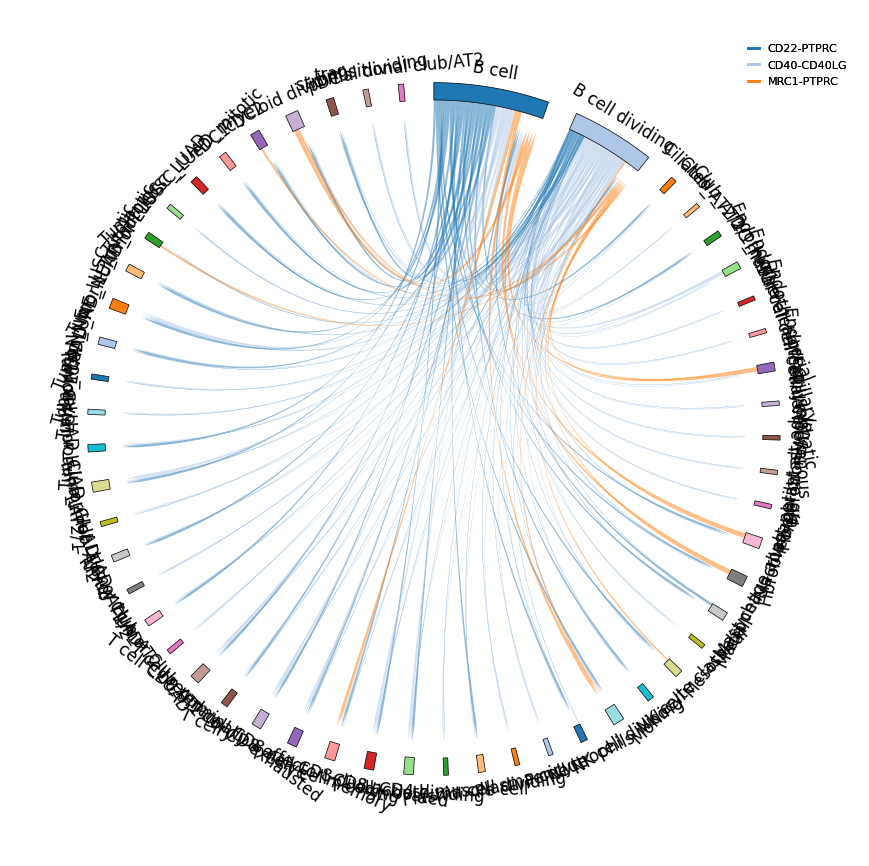

In [ ]:
kpy.plot_cpdb_chord(
    adata=adata,
    cell_type1="B cell",
    cell_type2=".",
    means=means,
    pvals=pvals,
    deconvoluted=decon,
    celltype_key="cell_type",
    interaction=["PTPRC", "CD40"],
    # link_kwargs={"direction": 1, "allow_twist": True, "r1": 95, "r2": 90},
    # sector_text_kwargs={"color": "black", "size": 12, "r": 105, "adjust_rotation": True},
    legend_kwargs={"loc": "center", "bbox_to_anchor": (1, 1), "fontsize": 8},
    link_offset=1,
)

In [45]:
adata.obs.reset_index(inplace=True)

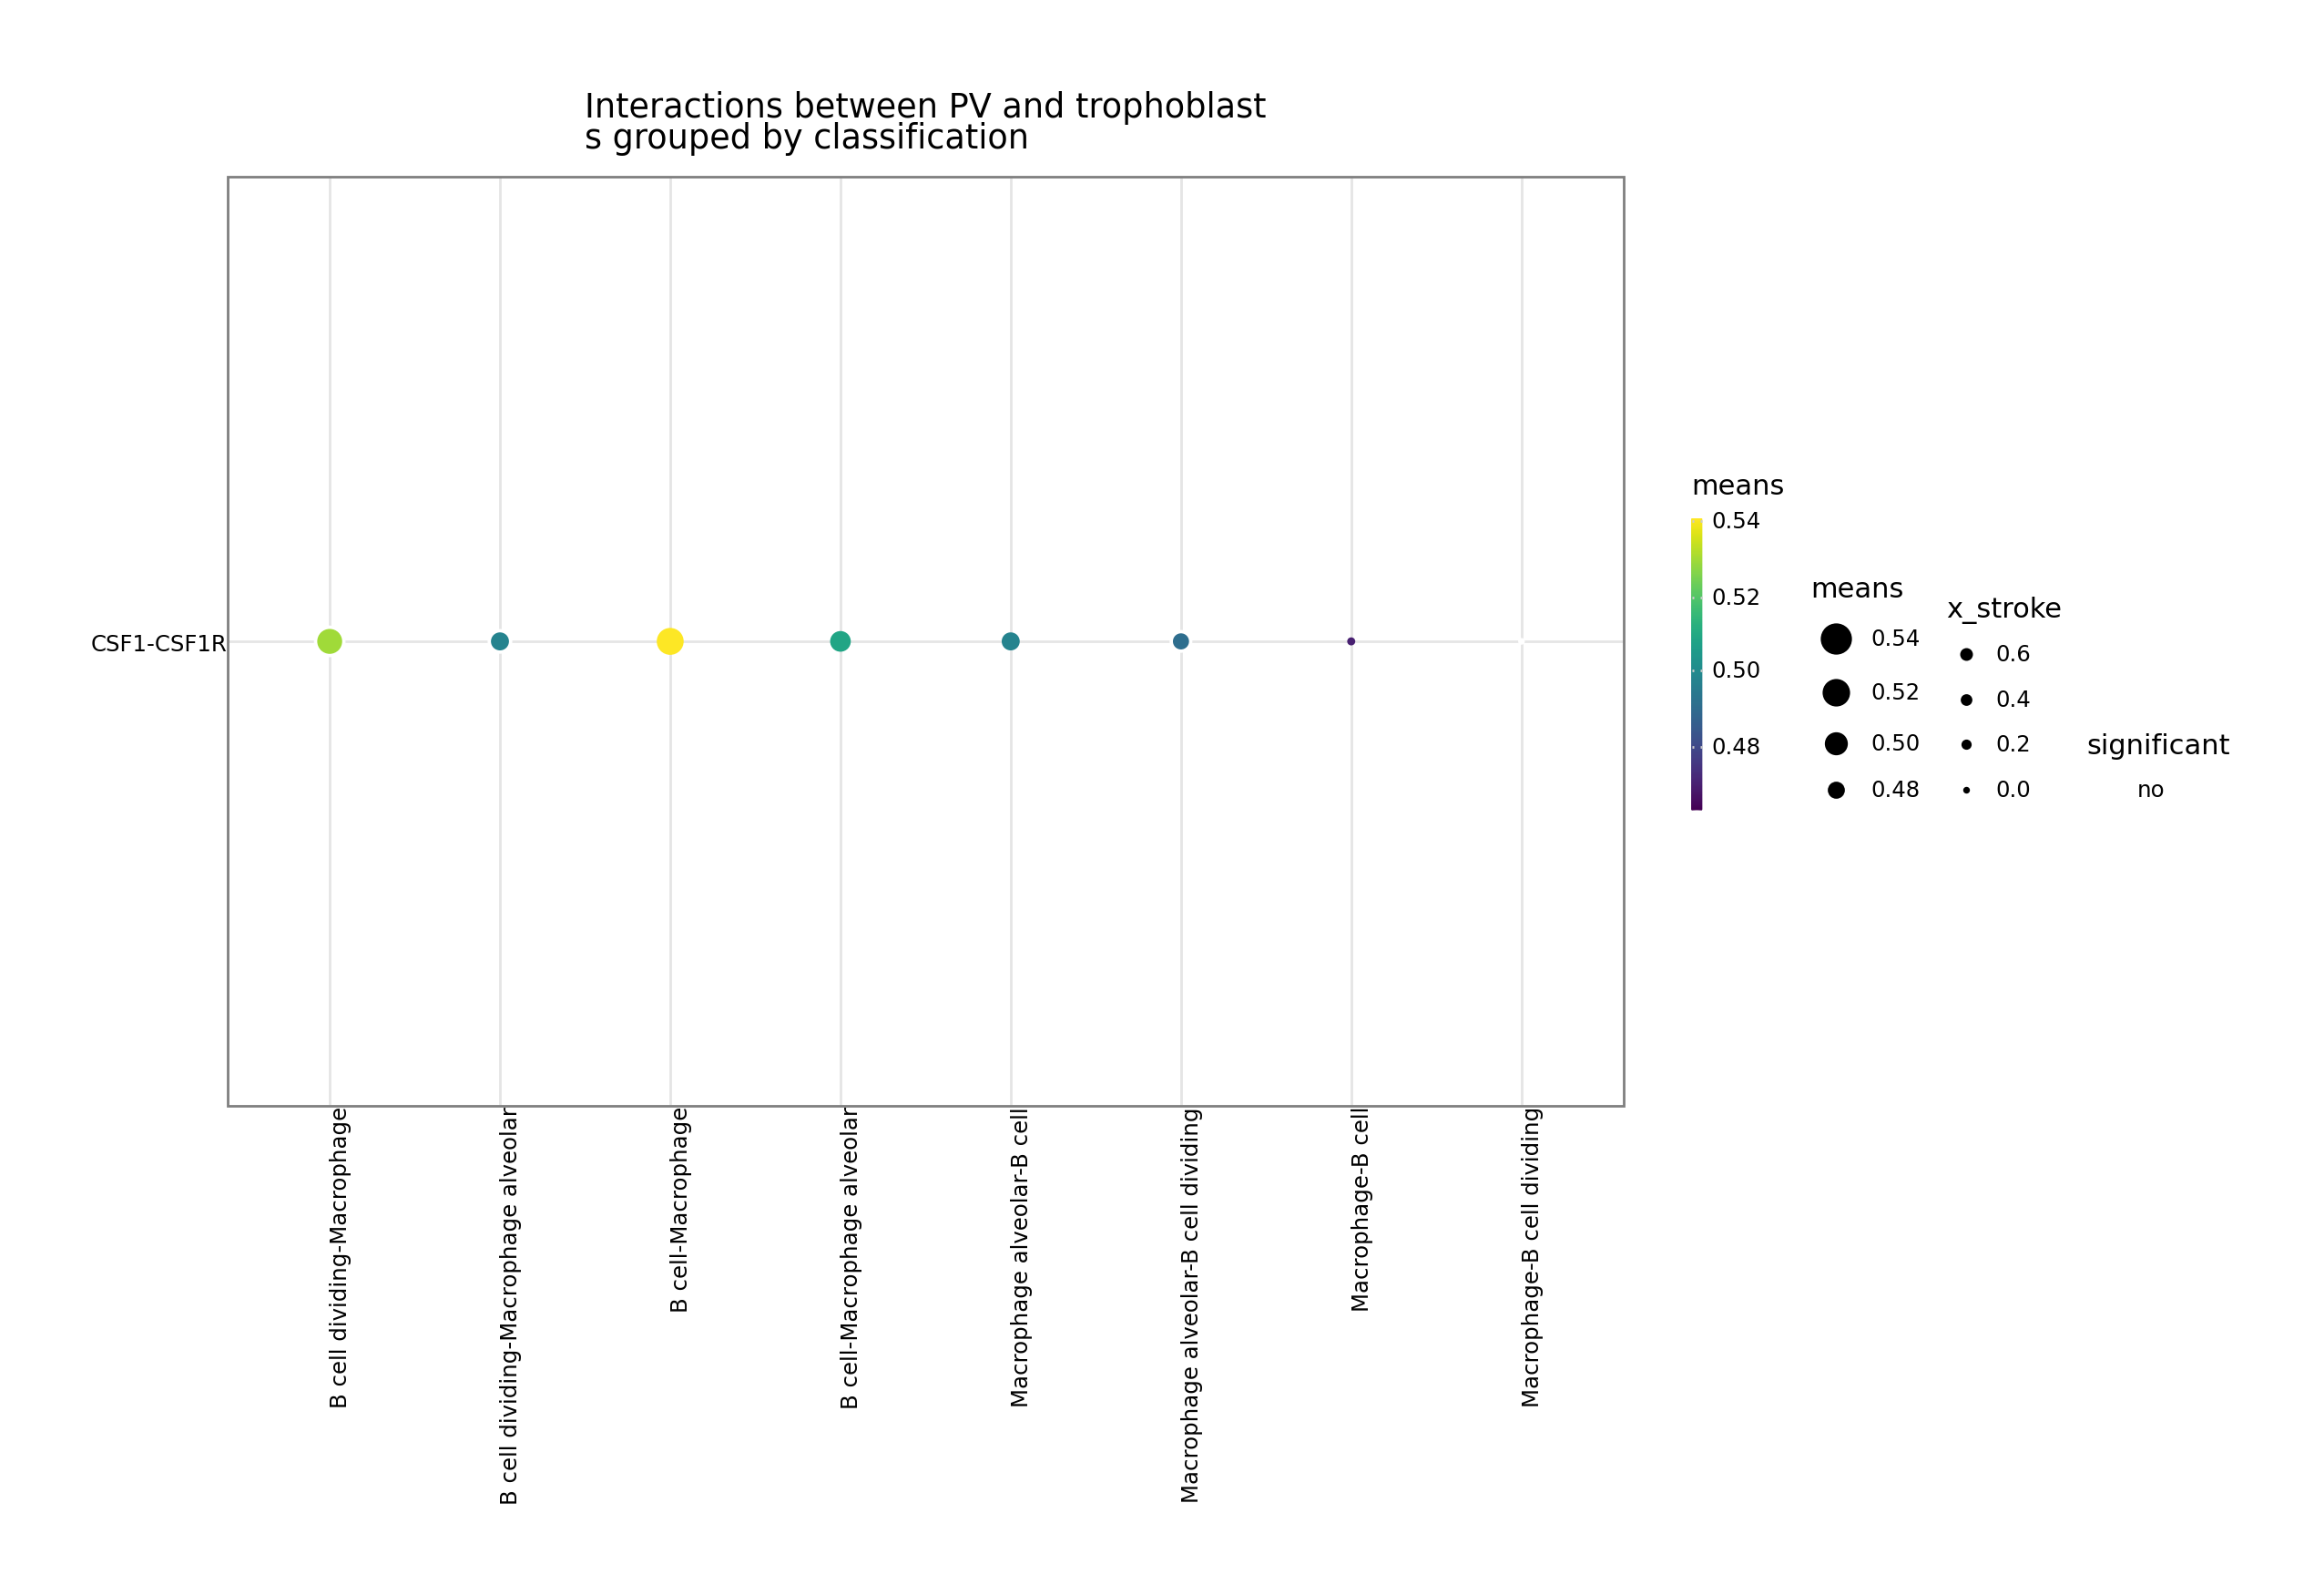

In [ ]:


from plotnine import facet_wrap

kpy.plot_cpdb(
    adata = adata,
    cell_type1 = "B cell", # very IMPORTANT that the cell types are the same as in the metadata, if not it will create a df that contaIns strings
    cell_type2 = "Macrophage",
    means = cpdb_results['means'],
    pvals = cpdb_results['pvalues'],
    interaction_scores= cpdb_results['interaction_scores'],
    celltype_key = "cell_type",
    genes = ["TGFB2", "CSF1R", "COL1A1"],
    figsize = (12, 8),
    title = "Interactions between B cells and Macrophage",
    max_size = 6,
    highlight_size = 0.75,
    degs_analysis = False,
    standard_scale = False,
    keep_significant_only=False
)
# p + facet_wrap("~ classification", ncol = 1)



In [47]:
adata.to_df().index

RangeIndex(start=0, stop=128, step=1)